# Material de Geofísica - Gamaespectrometria - Mapa de eTh Lunar
#### Curso de Geologia - Geofísica Aplicada - 2o Semestre 2024
Profa. Luizemara Szameitat
![Banner USP](https://raw.githubusercontent.com/lszam/geofex/main/assets/img/banner_usp.png)

OBJETIVO: Exercitar a busca, obtenção e análise expedita de dados públicos.

In [23]:
###DEIXE O SEU NOME REGISTRADO!!!####

aluno = 'Insira seu nome aqui'

In [61]:
!pip install spacepy matplotlib -q

!pip install cmcrameri -q

import cmcrameri.cm as cmc # tabela de cores perceptualmente uniformes de Fabio Crameri https://www.fabiocrameri.ch/visualisation/#ws-block-product-with-media-vxklWa2e

A bibiloteca SpacePy precisa do arquivo localmente, então primeiro precisamos baixar

In [37]:
import requests

# URL do arquivo CDF no GitHub
url = 'https://github.com/lszam/geofex/raw/refs/heads/main/data/Gama_Lua/GRS_ThK_high1_V002.cdf'
#fonte original: página https://pds-geosciences.wustl.edu/missions/lunarp/level1.html

filename = 'GRS_ThK_high1_V002.cdf'

response = requests.get(url)

with open(filename, 'wb') as f:
    f.write(response.content)

print(f'{filename} foi baixado com sucesso!')

GRS_ThK_high1_V002.cdf foi baixado com sucesso!


In [38]:
#Carregar os dados
from spacepy import pycdf
import matplotlib.pyplot as plt

# Carregar o arquivo CDF
filename = 'GRS_ThK_high1_V002.cdf'
cdf_data = pycdf.CDF(filename)

# Ver as variáveis presentes no arquivo
print("Variáveis disponíveis no arquivo:")
print(cdf_data.keys())

Variáveis disponíveis no arquivo:
KeysView(<CDF:
Nspectra: CDF_INT2 [1790]
Pixel: CDF_FLOAT [1790, 4]
Potassium: CDF_FLOAT [1790, 2]
Record: CDF_INT2 [1790]
Thorium: CDF_FLOAT [1790, 2]
>)


Observamos que os dados de tório estão organizados na variável Thorium, que contém uma matriz de 1790 linhas e 2 colunas. O endereço de cada pixel deve estar na variável Pixel. Vamos ver?

In [39]:
# Acessar os dados de 'Pixel'
pixel_data = cdf_data['Pixel'][:]

# Ver as primeiras linhas dos dados de Pixel para identificar as colunas
print("Primeiros dados de 'Pixel':")
print(pixel_data[:10])

Primeiros dados de 'Pixel':
[[ -90.   -87.5 -180.   180. ]
 [ -87.5  -82.5 -180.  -135. ]
 [ -87.5  -82.5 -135.   -90. ]
 [ -87.5  -82.5  -90.   -45. ]
 [ -87.5  -82.5  -45.     0. ]
 [ -87.5  -82.5    0.    45. ]
 [ -87.5  -82.5   45.    90. ]
 [ -87.5  -82.5   90.   135. ]
 [ -87.5  -82.5  135.   180. ]
 [ -82.5  -77.5 -180.  -156. ]]


**Pixel: as colunas representam intervalos de latitude e longitude para cada célula (ou pixel) no mapa.**
* Coluna 0: Latitude mínima do pixel
* Coluna 1: Latitude máxima do pixel
* Coluna 2: Longitude mínima do pixel
* Coluna 3: Longitude máxima do pixel

Para gerar um mapa de distribuição de tório, podemos calcular a latitude média e a longitude média para cada célula, para **obter a localização do centro do pixel**.

In [40]:
# Calcular a latitude e longitude médias para cada pixel
latitude = (pixel_data[:, 0] + pixel_data[:, 1]) / 2
longitude = (pixel_data[:, 2] + pixel_data[:, 3]) / 2

# Ver as 10primeiras coordenadas calculadas:
print("Latitude média:", latitude[:10])
print("Longitude média:", longitude[:10])

Latitude média: [-88.75 -85.   -85.   -85.   -85.   -85.   -85.   -85.   -85.   -80.  ]
Longitude média: [   0.  -157.5 -112.5  -67.5  -22.5   22.5   67.5  112.5  157.5 -168. ]


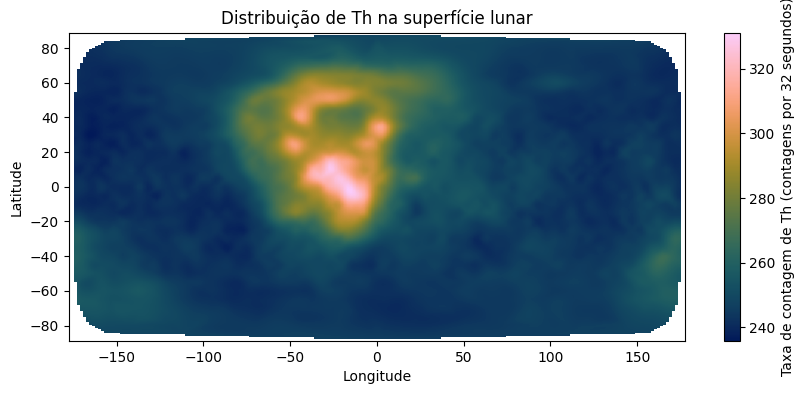

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Acessar os dados de tório (primeira coluna de contagens)
thorium_data = cdf_data['Thorium'][:, 0]  # Primeira coluna de tório (contagens)


### CRIAR UMA MADA DE DISTRIBUIÇÃO DE TÓRIO ###

# Definir os limites do grid
lat_min, lat_max = np.min(latitude), np.max(latitude)
lon_min, lon_max = np.min(longitude), np.max(longitude)

# Gerar grid 2D
grid_lat, grid_lon = np.mgrid[lat_min:lat_max:200j, lon_min:lon_max:200j]
# Interpolar dados de Th na grade regular com a função griddata, método de interpolação cúbico
grid_thorium = griddata((latitude, longitude), thorium_data, (grid_lat, grid_lon), method='cubic')

# Plotar os dados interpolados com imshow (raster)
plt.figure(figsize=(10, 4))
plt.imshow(grid_thorium, extent=(lon_min, lon_max, lat_min, lat_max), origin='lower', cmap=cmc.batlow)
plt.colorbar(label='Taxa de contagem de Th (contagens por 32 segundos)')
plt.title('Distribuição de Th na superfície lunar')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


Na GAMAESPECTROMETRIA, os dados de Tório são geralmente apresentados em "equivalente em Th" (eTh), uma unidade que representa o Th em partes por milhão (ppm).
Mas os dados brutos, como obtidos pelo sensor, são em contagens por segundo (cps). Par realizar a conversão para equivalente em ppm, usa-se um fator específico, determinado por calibrações feitas com o sensor pela leitura de padrões conhecidos do elemento. Como padrões, são usados "pads" ou pistas de calibração, que contém um valor conhecido de U, Th e K. A conversão também leva em consideração condições específicas do detector e do ambiente.

As correçoes para dados da Terra usam um valor entorno de 0.01 a 0.05 ppm/contagem. Para a Lua, não tive tempo de consultar o valor, então vamos assumir uma valor dentro deste intervalo para obtermos um valor em partes por milhão para este dado. Se alguém conseguir realizar esta consulta, pode compartilhar com a turma!


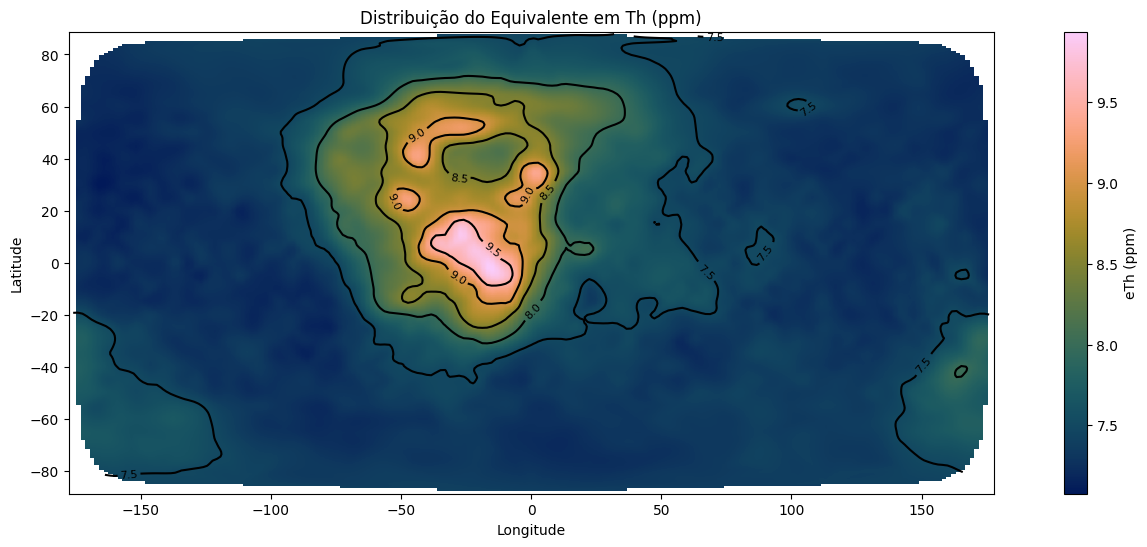

In [68]:
# Fator de conversão
C = 0.03  # ppm/contagem

# Aplicar a conversão para abundância de Tório (ppm)
grid_thorium_ppm = C * grid_thorium  # grid_thorium contém as taxas de contagem/segundo

# Exibir o mapa do Equivalenete em Tório
# Recursos adicionais no mapa abaixo: curvas de isovalores
plt.figure(figsize=(18, 6))
plt.imshow(grid_thorium_ppm, extent=(lon_min, lon_max, lat_min, lat_max), origin='lower', cmap=cmc.batlow)
plt.colorbar(label='eTh (ppm)')
contours = plt.contour(grid_lon, grid_lat, grid_thorium_ppm, levels=6, colors='black')
plt.clabel(contours, inline=True, fontsize=8)
plt.title('Distribuição do Equivalente em Th (ppm)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Fechar o arquivo CDF após o uso
cdf_data.close()

#**Exportar como grid para o QGIS**

In [31]:
!pip install gdal -q  #GDAL (Geospatial Data Abstraction Library)

**Código para salvar em grid tipo surfer:**

In [62]:
import numpy as np
from osgeo import gdal, osr

# Obter numero de linhas e colunas do grid criado anterirmente
nrows, ncols = grid_thorium_ppm.shape

# No GDAL, é preciso "criar um driver" para selecionar e inicializar um módulo
# que permite ler ou escrever dados em um formato de arquivo específico. Cada
# formato de arquivo que quisermos usar para obter a saída
# (GeoTIFF, NetCDF, Surfer, etc.) tem um driver específico no GDAL que permitirá
# a leitura ou a gravação de dados no formato escolhido.

# Criar um driver para o formato Surfer v7
driver = gdal.GetDriverByName('GS7BG')

### CRIAR O ARQUIVO DE SAÍDA ###

# Nome do arquivo de saída
output_file = 'ethorium_grid.srf'
# Criar arquivo
dataset = driver.Create(output_file, ncols, nrows, 1, gdal.GDT_Float32)

# Definir a projeção espacial (neste caso, estamos usando WGS84)
srs = osr.SpatialReference()
srs.SetWellKnownGeogCS('WGS84')
dataset.SetProjection(srs.ExportToWkt())

# Definir o tamanho do grid
lon_min, lon_max = np.min(grid_lon), np.max(grid_lon)
lat_min, lat_max = np.min(grid_lat), np.max(grid_lat)
dataset.SetGeoTransform([lon_min, (lon_max - lon_min) / ncols, 0, lat_max, 0, (lat_min - lat_max) / nrows]) # define os limites

# Escrever os dados no arquivo
dataset.GetRasterBand(1).WriteArray(grid_thorium_ppm)

# Fechar o arquivo
dataset.FlushCache()
dataset = None

print(f"Arquivo {output_file} salvo com sucesso!")

Arquivo ethorium_grid.srf salvo com sucesso!


**Código para salvar em arquivo do tipo GeoTiff:**

In [63]:
import numpy as np
from osgeo import gdal, osr

output_file = 'ethorium_grid.tif'

nrows, ncols = grid_thorium_ppm.shape

driver = gdal.GetDriverByName('GTiff')

dataset = driver.Create(output_file, ncols, nrows, 1, gdal.GDT_Float32)

# Projeção espacial
srs = osr.SpatialReference()
srs.SetWellKnownGeogCS('WGS84')
dataset.SetProjection(srs.ExportToWkt())

# Definir a extensão do grid
lon_min, lon_max = np.min(grid_lon), np.max(grid_lon)
lat_min, lat_max = np.min(grid_lat), np.max(grid_lat)

# Definir os limites do grid
dataset.SetGeoTransform([lon_min, (lon_max - lon_min) / ncols, 0, lat_max, 0, (lat_min - lat_max) / nrows])

# Escrever os dados no arquivo
dataset.GetRasterBand(1).WriteArray(grid_thorium_ppm)

# Fechar o arquivo
dataset.FlushCache()
dataset = None

print(f"Arquivo {output_file} salvo com sucesso!")


Arquivo ethorium_grid.tif salvo com sucesso!
